### Config the model

In [103]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-2.5-flash-preview-05-20')

### Config the embedding model

In [104]:
import os
os.environ['HF_TOKEN']=os.getenv("HUGGINGFACEHUB_API_TOKEN")
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

## lets take a data embedd it and store in VDB

In [105]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [106]:
loader=DirectoryLoader("../data2",glob="./*.txt",loader_cls=TextLoader) 
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)
new_docs=text_splitter.split_documents(documents=docs)
doc_string=[doc.page_content for doc in new_docs] # we dropped the metadata


In [107]:
db=Chroma.from_documents(new_docs,embeddings) # in-memory vector DB

In [108]:
retriever=db.as_retriever(search_kwargs={"k": 3})

## creation of pydantic class

In [109]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
from dotenv import load_dotenv
load_dotenv()

True

In [110]:
from typing import Literal
class TopicSelectionParser(BaseModel):
  # to decrease halucination, first do reasoning and then topic
  Reasoning: str = Field(description='Reasoning behind topic selection')
  Topic: Literal["USA", "Web", "Not Related"] = Field(description="selected topic")

In [111]:
from langchain.output_parsers import PydanticOutputParser
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [112]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [113]:
from langchain_core.messages import AIMessage
def function_1(state:AgentState): # state should be of AgentState type
    
    question=state["messages"][0].content # we take latest message (recent) -> this is a BaseMessage object
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [USA, Web, Not Related]. 
    Only respond with the category name and nothing else. Respond USA if the query is about the US economy,
    respond Web if the query requires to look for the latest information in the internet (e.g. current weather),
    respond Not Related if the query is not related to USA or Web and you can answer it using your knowledge.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()} # parser was defined outside of the function and it's a PydanticOutputParser
    ) # partial variables are those which enter the prompt but they are not part of the chain invoke
    
    
    chain= prompt | model | parser 
    # we pass the question to the prompt, then the llm model takes the prompt and outputs the response,
		# and then this response is evaluated by parser to have the right format
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [AIMessage(content=response.Topic)]} # now it's like a new message in the state

In [114]:
def router(state: AgentState):
    print("-> ROUTER ->")
    last_message = state["messages"][-1].content
    print(f"Router input (last message): '{last_message}'")
    
    if "usa" in last_message.lower():
        result = "RAG Call"
    elif "web" in last_message.lower():
        result = "Web Call"
    else:
        result = "LLM Call"
    
    print(f"Router output: '{result}'")
    return result

In [115]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [116]:
# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0].content 
    print("Question",question)
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks.
                  Use the following pieces of retrieved context to answer the question.
									If you don't know the answer, just say that you don't know.
									Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
# retriever is from RAG db. It searches for similar outputs in db based on question and returns the context    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()} 
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [AIMessage(content=result)]}

In [117]:
# LLM Function
def function_3(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0].content
    print("Question",question)
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [AIMessage(content=response.content)]}

In [118]:
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
def format_tavily_results(results):
  return "\n\n".join([
    f"Title: {result['title']}\nContent: {result['content']}" 
    for result in results
  ])
# Web Call Function
def function_4(state:AgentState):
	print("-> Web Call ->")
	question = state["messages"][0].content
	print("Question",question)
	web_search = format_tavily_results(tool.invoke({"query": question, "max_results": 5}))
	prompt=PromptTemplate(
	template="""You are an assistant for question-answering tasks.
						Use the following pieces of the latest fetched web news to answer the question.
						If you don't know the answer, just say that you don't know.
						Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",

	input_variables=['context', 'question'])
	# Normal LLM call
	chain = prompt | model
	response = chain.invoke({"question": question, "context": web_search})
	return {"messages": [AIMessage(content=response.content)]}

In [119]:
class ValidationParser(BaseModel):
  # to decrease halucination, first do reasoning and then topic
  Reasoning: str = Field(description='Reasoning behind validation output')
  Validation: Literal["Pass", "Fail"] = Field(description="validation based on question and answer")

validation_parser=PydanticOutputParser(pydantic_object=ValidationParser)

In [120]:
# Validation Function
def function_5(state:AgentState):
	print("-> Validation Call ->")
	question = state["messages"][0].content
	print("Question",question)
	answer = state["messages"][-1].content
	print("Question",answer)
	# first is question, then supervisor output, then answer
	prompt=PromptTemplate(
	template="""You are a validator of a question-answering task.
Your task is to validate the answer based on the given question and to
classify it into one of the following categories: [Pass, Fail]. 
Classify Pass if:
 - the answer is correct and the question is related to the answer.
Classify Fail if:
 - the answer does not logically match the question.
Only respond with the category name and nothing else.

{format_instructions}
\nQuestion: {question} \nAnswer: {answer} \nClassification:""",
	input_variables=['answer', 'question'],
	partial_variables={"format_instructions": validation_parser.get_format_instructions()})
	chain = prompt | model | validation_parser
	response = chain.invoke({'question': question, 'answer': answer})
	return {"messages": [AIMessage(content=response.Validation)]}

In [121]:
def validation_router(state: AgentState):
  print("-> VALIDATION ROUTER ->")
  
  last_message = state["messages"][-1].content
  print("Validation result:", last_message)
  
  if "pass" in last_message.lower():
    return "END"
  else:
    return "SUPERVISOR"  # Go back to supervisor for retry

In [122]:
from langgraph.graph import StateGraph,END

In [123]:
workflow=StateGraph(AgentState) # we tell langgraph that we are dealing with AgentState
workflow.add_node("Supervisor",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.add_node("Web",function_4)
workflow.add_node("Validation",function_5)

In [124]:
# Connect worker nodes to Validation
workflow.add_edge("RAG", "Validation")
workflow.add_edge("LLM", "Validation") 
workflow.add_edge("Web", "Validation")

In [125]:
workflow.set_entry_point("Supervisor") # start of the graph

one conditional edge -> one if else function

In [126]:
# First conditional edge: Supervisor to workers
# Note: LangGraph automatically adds END edge as fallback for unmapped values
workflow.add_conditional_edges(
  "Supervisor",  # FROM this node
  router,        # Use this function to decide
  {              # Map router output to next nodes
    "RAG Call": "RAG",  # If router returns "RAG Call", go to RAG node
    "LLM Call": "LLM",  # If router returns "LLM Call", go to LLM node
    "Web Call": "Web",  # If router returns "Web Call", go to Web node
  }
)

# Second conditional edge: Validation to END or back to Supervisor
workflow.add_conditional_edges(
  "Validation",
  validation_router,
  {
    "END": END,           # If validation passes, end workflow
    "SUPERVISOR": "Supervisor"  # If validation fails, go back to supervisor
  }
)

In [127]:
app = workflow.compile()

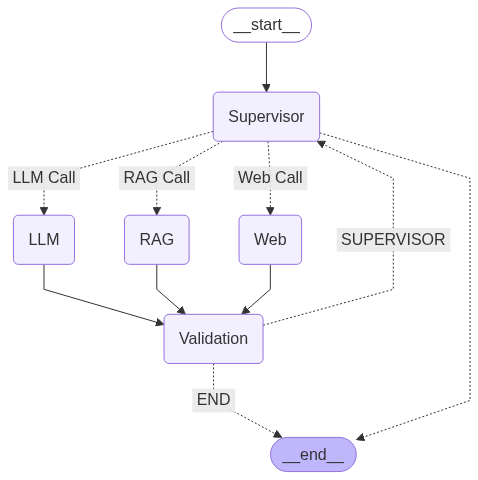

In [128]:
workflow.compile()


In [129]:
from langchain_core.messages import HumanMessage

state = {"messages": [HumanMessage(content="what is the weather today in Prague?")]}

In [130]:
app.invoke(state)

Question what is the weather today in Prague?
Parsed response: Reasoning="The query asks for 'today's' weather, which is dynamic and requires looking up the latest information on the internet." Topic='Web'
-> ROUTER ->
Router input (last message): 'Web'
Router output: 'Web Call'
-> Web Call ->
Question what is the weather today in Prague?
-> Validation Call ->
Question what is the weather today in Prague?
Question I don't know the weather today in Prague. The provided information only contains weather forecasts and historical data for October 2025.
-> VALIDATION ROUTER ->
Validation result: Pass


{'messages': [HumanMessage(content='what is the weather today in Prague?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Web', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't know the weather today in Prague. The provided information only contains weather forecasts and historical data for October 2025.", additional_kwargs={}, response_metadata={}),
  AIMessage(content='Pass', additional_kwargs={}, response_metadata={})]}

In [131]:
state = {"messages": [HumanMessage(content="what is a gdp of usa?")]}

In [132]:
app.invoke(state)

Question what is a gdp of usa?
Parsed response: Reasoning="The user query 'what is a gdp of usa?' directly pertains to the economy of the United States, which aligns with the definition of the 'USA' category." Topic='USA'
-> ROUTER ->
Router input (last message): 'USA'
Router output: 'RAG Call'
-> RAG Call ->
Question what is a gdp of usa?
-> Validation Call ->
Question what is a gdp of usa?
Question I don't know the answer based on the provided context. The context only mentions "U.S. GDP – Size, Composition, and Global Share" but does not state the specific GDP figure.
-> VALIDATION ROUTER ->
Validation result: Pass


{'messages': [HumanMessage(content='what is a gdp of usa?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='USA', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I don\'t know the answer based on the provided context. The context only mentions "U.S. GDP – Size, Composition, and Global Share" but does not state the specific GDP figure.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Pass', additional_kwargs={}, response_metadata={})]}

In [133]:
state = {"messages": [HumanMessage(content="can you tell me the industrial growth of world's most powerful economy?")]}

In [134]:
app.invoke(state)

Question can you tell me the industrial growth of world's most powerful economy?
Parsed response: Reasoning="The phrase 'world's most powerful economy' is widely recognized as referring to the United States. The query asks about 'industrial growth', which is an economic indicator. Therefore, the query is about the US economy." Topic='USA'
-> ROUTER ->
Router input (last message): 'USA'
Router output: 'RAG Call'
-> RAG Call ->
Question can you tell me the industrial growth of world's most powerful economy?
-> Validation Call ->
Question can you tell me the industrial growth of world's most powerful economy?
Question Based on the provided context, the United States of America has the largest economy in the world, making it the most powerful economic force globally. However, the context does not provide information regarding its industrial growth. Therefore, I don't know the answer.
-> VALIDATION ROUTER ->
Validation result: Pass


{'messages': [HumanMessage(content="can you tell me the industrial growth of world's most powerful economy?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='USA', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Based on the provided context, the United States of America has the largest economy in the world, making it the most powerful economic force globally. However, the context does not provide information regarding its industrial growth. Therefore, I don't know the answer.", additional_kwargs={}, response_metadata={}),
  AIMessage(content='Pass', additional_kwargs={}, response_metadata={})]}

In [135]:
state = {"messages": [HumanMessage(content="can you tell me the industrial growth of world's poor economy?")]}

In [136]:
app.invoke(state)

Question can you tell me the industrial growth of world's poor economy?
Parsed response: Reasoning="The query asks for 'industrial growth of world's poor economy'. This information is dynamic and requires looking up current or recent economic data, reports, and statistics, which are best found on the internet. It's not a static piece of general knowledge, nor is it specifically about the US economy." Topic='Web'
-> ROUTER ->
Router input (last message): 'Web'
Router output: 'Web Call'
-> Web Call ->
Question can you tell me the industrial growth of world's poor economy?
-> Validation Call ->
Question can you tell me the industrial growth of world's poor economy?
Question The provided text indicates that industrialization is often essential for economic growth and long-run poverty reduction, and that rapid economic growth in population-rich countries like China and India, driven by manufacturing, has benefited the poor. However, it also notes significant differences between countries re

{'messages': [HumanMessage(content="can you tell me the industrial growth of world's poor economy?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='Web', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The provided text indicates that industrialization is often essential for economic growth and long-run poverty reduction, and that rapid economic growth in population-rich countries like China and India, driven by manufacturing, has benefited the poor. However, it also notes significant differences between countries regarding industrialization\'s impact on the poor. The text does not provide a specific industrial growth rate for the world\'s poor economies as a whole, though it mentions that "poor countries with very little income growth" exist and that the world\'s poorest nations risk being left further behind in industrial development.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Pass', additional_kwargs={}, response_metadata